In [2]:
# sliding window GRU with updated preprocessing and stratified splits
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
nltk.download('stopwords')
# Load and preprocess data
SEED = 42
np.random.seed(SEED)
df = pd.read_csv("msd_dataset_enriched_with_similar_songs.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Claudia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]

In [5]:
# Dynamically downsample overly dominant genres
threshold = 0.3 * len(df)  # e.g., no class should take more than 30% of the data
balanced_dfs = []
for genre, count in df['genre'].value_counts().items():
    genre_df = df[df['genre'] == genre]
    if count > threshold:
        genre_df = resample(genre_df, replace=False, n_samples=int(threshold), random_state=SEED)
    balanced_dfs.append(genre_df)
df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED)

In [6]:
# Tokenization
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
tokenizer.word_index = filtered_index
tokenizer.index_word = {i: word for word, i in filtered_index.items()}

In [7]:
# Create sliding windows
def create_sliding_windows(seq, window_size=100, step_size=50):
    windows = []
    for start in range(0, len(seq) - window_size + 1, step_size):
        windows.append(seq[start:start+window_size])
    if not windows and len(seq) > 0:
        windows.append(seq[:window_size])
    return windows

In [8]:
X_seq = []
y_seq = []
labels = df['genre'].tolist()
tokenized_seqs = tokenizer.texts_to_sequences(df['cleaned_lyrics'])

for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    for window in windows:
        padded = pad_sequences([window], maxlen=100)[0]
        X_seq.append(padded)
        y_seq.append(labels[i])

X = np.array(X_seq)
le = LabelEncoder()
y_labels = le.fit_transform(y_seq)
y = to_categorical(y_labels)

embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
for word, i in filtered_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [9]:
# Metadata features
meta_features = ['duration','tempo','key','loudness'] + [
    f'pitch_mean_{i}' for i in range(12)
] + [f'pitch_std_{i}' for i in range(12)] + [f'timbre_mean_{i}' for i in range(12)] + [f'timbre_std_{i}' for i in range(12)]
df[meta_features] = df[meta_features].fillna(0)
scaler = StandardScaler()
# Expand metadata to align with sliding windows
meta_rows = []
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    num_windows = len(windows)
    meta_row = df.iloc[i][meta_features].values
    for _ in range(num_windows):
        meta_rows.append(meta_row)

X_meta_all = np.array(meta_rows)
X_meta_all = scaler.fit_transform(X_meta_all)

In [10]:
# Split
X_train_lyrics, X_temp_lyrics, X_train_meta, X_temp_meta, y_train, y_temp, y_train_labels, y_temp_labels = train_test_split(
    X, X_meta_all, y, y_labels, test_size=0.3, stratify=y_labels, random_state=SEED
)

X_val_lyrics, X_test_lyrics, X_val_meta, X_test_meta, y_val, y_test, y_val_labels, y_test_labels = train_test_split(
    X_temp_lyrics, X_temp_meta, y_temp, y_temp_labels, test_size=0.5, stratify=y_temp_labels, random_state=SEED
)

# Build and train model
input_lyrics = Input(shape=(100,))
x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
              weights=[embedding_matrix], trainable=False)(input_lyrics)
x = Bidirectional(GRU(64))(x)
x = Dropout(0.3)(x)

input_meta = Input(shape=(X_train_meta.shape[1],))
combined = Concatenate()([x, input_meta])
output = Dense(y.shape[1], activation='softmax')(combined)

In [11]:
model = Model(inputs=[input_lyrics, input_meta], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.fit([X_train_lyrics, X_train_meta], y_train,
          validation_data=([X_val_lyrics, X_val_meta], y_val),
          batch_size=64, epochs=20, callbacks=[early], verbose=1)

# Evaluate
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
y_true = y_test_labels

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.1734 - loss: 2.7971 - val_accuracy: 0.3704 - val_loss: 2.2223
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3995 - loss: 2.1086 - val_accuracy: 0.4160 - val_loss: 2.0039
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4459 - loss: 1.9392 - val_accuracy: 0.4359 - val_loss: 1.9121
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4521 - loss: 1.8330 - val_accuracy: 0.4501 - val_loss: 1.8488
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4881 - loss: 1.7341 - val_accuracy: 0.4530 - val_loss: 1.8081
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.4891 - loss: 1.6593 - val_accuracy: 0.4701 - val_loss: 1.7836
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.4997 - loss: 1.6137 - val_accuracy: 0.4729 - val_loss: 1.7549
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5177 - loss: 1.5649 - val_accuracy: 0.4815


Test Accuracy: 0.47293447293447294

Classification Report:
              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00         8
     Country       0.18      0.12      0.14        17
  Electronic       1.00      0.10      0.18        10
        Folk       0.00      0.00      0.00         3
        Jazz       0.00      0.00      0.00        13
       Latin       0.50      0.29      0.36         7
       Metal       0.33      0.22      0.26        23
         Pop       0.26      0.24      0.25        41
    Pop Rock       0.25      0.08      0.12        13
        Punk       0.00      0.00      0.00        11
         Rap       0.73      0.81      0.77        83
      Reggae       0.50      0.25      0.33        16
         RnB       0.00      0.00      0.00         6
        Rock       0.43      0.82      0.57        90
  Rock Metal       0.00      0.00      0.00         6
   Rock Punk       0.00      0.00      0.00         4

    accuracy        

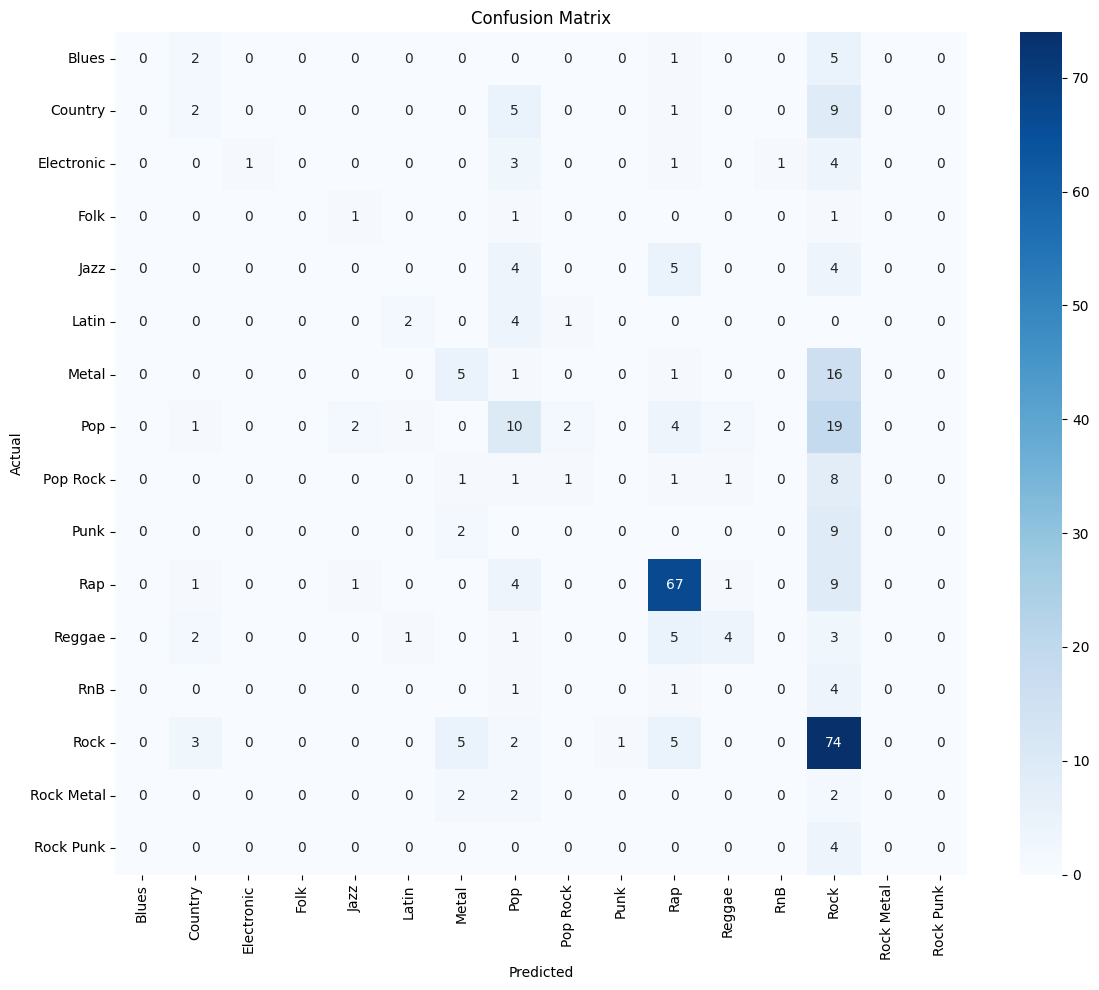

In [12]:
print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
# Predict
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
test_acc = accuracy_score(y_test_labels, y_pred)
print(f"Test Accuracy on held-out set: {test_acc:.4f}")

# Random sample of predictions vs actual
sample_idxs = np.random.choice(len(X_test_lyrics), size=5, replace=False)
for i in sample_idxs:
    actual = le.inverse_transform([y_test_labels[i]])[0]
    predicted = le.inverse_transform([y_pred[i]])[0]
    print(f"\nSample {i}")
    print("Actual Genre   :", actual)
    print("Predicted Genre:", predicted)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test Accuracy on held-out set: 0.4729

Sample 157
Actual Genre   : Pop
Predicted Genre: Pop

Sample 342
Actual Genre   : Rock
Predicted Genre: Rock

Sample 316
Actual Genre   : Jazz
Predicted Genre: Rap

Sample 234
Actual Genre   : Rock
Predicted Genre: Rock

Sample 155
Actual Genre   : Pop
Predicted Genre: Rock


### HYPERPARAMETER TUNING ###


Training with GRU units=32, dropout=0.2...
Validation Accuracy: 0.4986

Training with GRU units=32, dropout=0.3...
Validation Accuracy: 0.5071

Training with GRU units=32, dropout=0.5...
Validation Accuracy: 0.5157

Training with GRU units=64, dropout=0.2...
Validation Accuracy: 0.5185

Training with GRU units=64, dropout=0.3...
Validation Accuracy: 0.4843

Training with GRU units=64, dropout=0.5...
Validation Accuracy: 0.5157

Training with GRU units=128, dropout=0.2...
Validation Accuracy: 0.4900

Training with GRU units=128, dropout=0.3...
Validation Accuracy: 0.4615

Training with GRU units=128, dropout=0.5...
Validation Accuracy: 0.4786

✅ Best Validation Accuracy: 0.5185 with params: {'units': 64, 'dropout': 0.2}
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Classification Report (Best Model):
              precision    recall  f1-score   support

       Blues       1.00      0.12      0.22         8
     Country       0.40      0.24      0.30        17
  Electronic       1.00      0

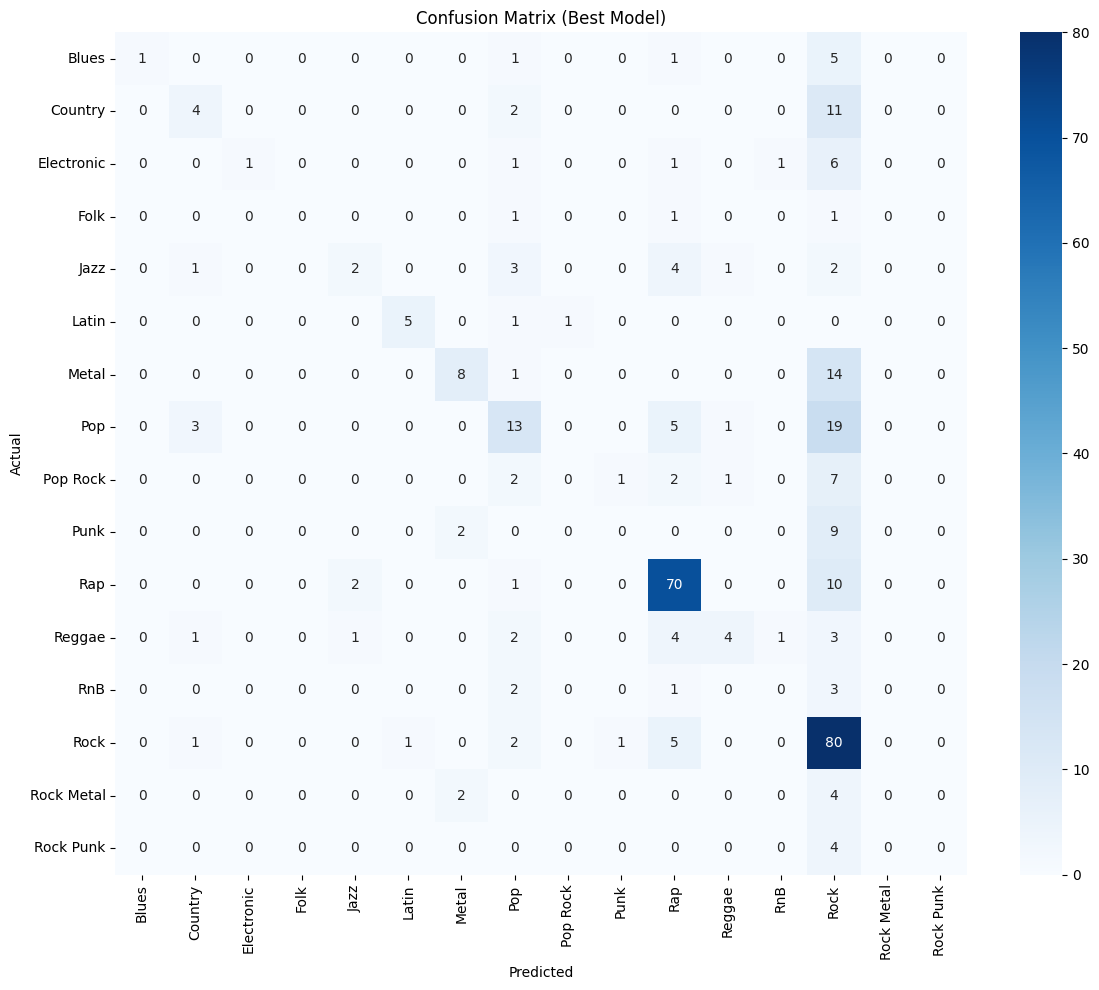

In [19]:
#Hyper param tuning
best_acc = 0
best_model = None
best_params = {}

for units in [32, 64, 128]:
    for dropout in [0.2, 0.3, 0.5]:
        print(f"\nTraining with GRU units={units}, dropout={dropout}...")

        # Build model
        input_lyrics = Input(shape=(100,))
        x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
                      weights=[embedding_matrix], trainable=False)(input_lyrics)
        x = Bidirectional(GRU(units))(x)
        x = Dropout(dropout)(x)

        input_meta = Input(shape=(X_train_meta.shape[1],))
        combined = Concatenate()([x, input_meta])
        output = Dense(y.shape[1], activation='softmax')(combined)

        model = Model(inputs=[input_lyrics, input_meta], outputs=output)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
        model.fit([X_train_lyrics, X_train_meta], y_train,
                  validation_data=([X_val_lyrics, X_val_meta], y_val),
                  batch_size=64, epochs=20, callbacks=[early], verbose=0)

        val_loss, val_acc = model.evaluate([X_val_lyrics, X_val_meta], y_val, verbose=0)
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model
            best_params = {"units": units, "dropout": dropout}

print(f"\n✅ Best Validation Accuracy: {best_acc:.4f} with params: {best_params}")

# Evaluate best model on test set
y_pred = np.argmax(best_model.predict([X_test_lyrics, X_test_meta]), axis=1)
print("\nClassification Report (Best Model):")
print(classification_report(y_test_labels, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### WITHOUT METADATA ###

In [14]:
def build_model(include_metadata=True, embedding_matrix=None, meta_dim=None, num_classes=None):
    input_lyrics = Input(shape=(100,))
    x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
                  weights=[embedding_matrix], trainable=False)(input_lyrics)
    x = Bidirectional(GRU(64))(x)
    x = Dropout(0.3)(x)

    if include_metadata:
        input_meta = Input(shape=(meta_dim,))
        combined = Concatenate()([x, input_meta])
        output = Dense(num_classes, activation='softmax')(combined)
        model = Model(inputs=[input_lyrics, input_meta], outputs=output)
    else:
        output = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=input_lyrics, outputs=output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
print("\nTraining lyrics-only model (no metadata)...")
model_lyrics_only = build_model(include_metadata=False,
                                embedding_matrix=embedding_matrix,
                                num_classes=y.shape[1])

early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_lyrics_only.fit(X_train_lyrics, y_train,
                      validation_data=(X_val_lyrics, y_val),
                      batch_size=64, epochs=20, callbacks=[early], verbose=1)

# Evaluate lyrics-only model
y_pred_lyrics = np.argmax(model_lyrics_only.predict(X_test_lyrics), axis=1)
print("\n[LYRICS ONLY] Classification Report:")
print(classification_report(y_test_labels, y_pred_lyrics, target_names=le.classes_))



Training lyrics-only model (no metadata)...
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.2133 - loss: 2.6360 - val_accuracy: 0.3846 - val_loss: 2.2031
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3685 - loss: 2.1846 - val_accuracy: 0.3846 - val_loss: 2.1044
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.3600 - loss: 2.1293 - val_accuracy: 0.4103 - val_loss: 2.0603
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4059 - loss: 2.0409 - val_accuracy: 0.4046 - val_loss: 2.0301
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.4031 - loss: 2.0103 - val_accuracy: 0.4188 - val_loss: 2.0143
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4085 - loss: 1.9763 - val_accuracy: 0.4160 - val_loss: 1.9629
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4274 - loss: 1.9509 - val_accuracy: 0.4302 - val_loss: 1.9547
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy:

/Users/Claudia/anaconda3/envs/tf_hw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Claudia/anaconda3/envs/tf_hw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Claudia/anaconda3/envs/tf_hw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

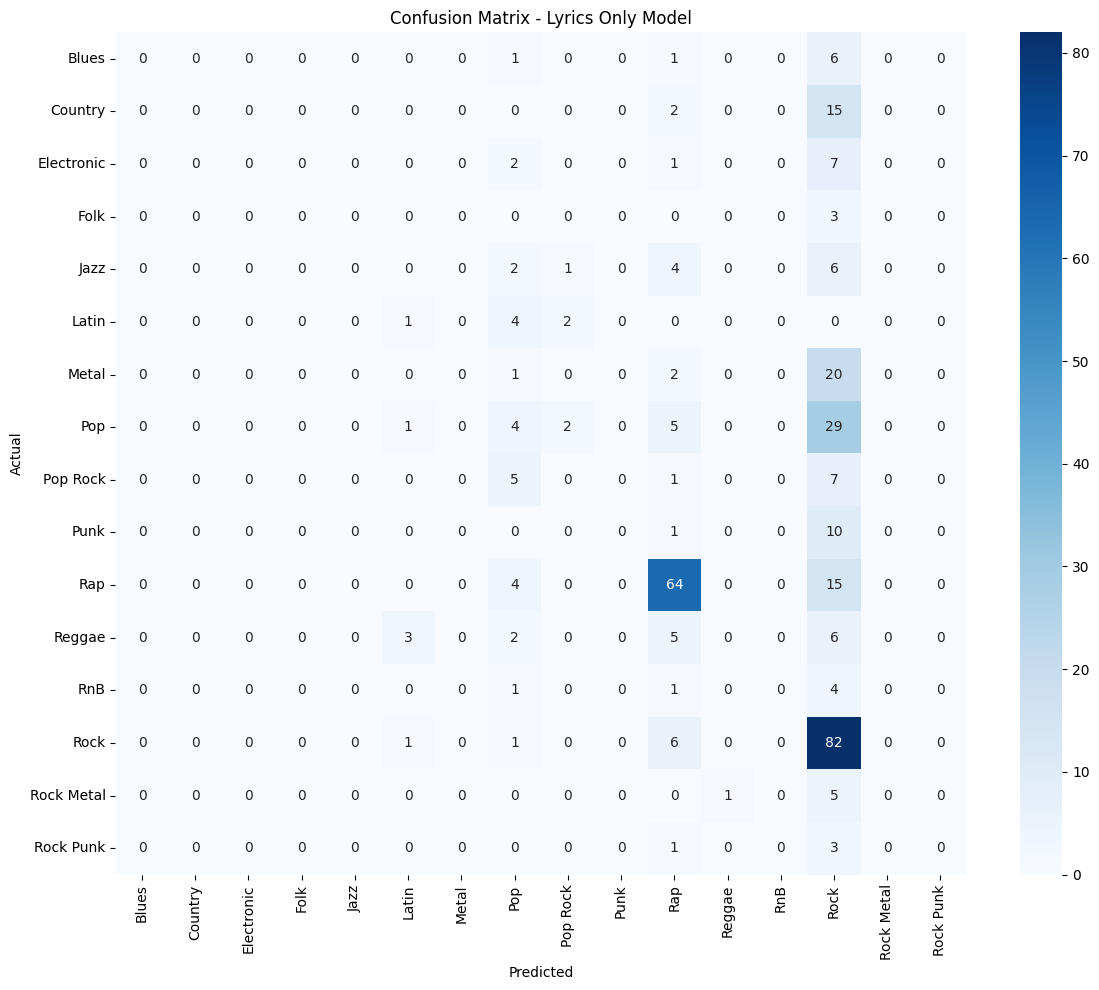

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_lyrics = confusion_matrix(y_test_labels, y_pred_lyrics)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_lyrics, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Lyrics Only Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
